## <u>Automated Classification of News for Easier Grouping using Machine Learning and Natural Language Processing. </u>

##Setting up the Notebook and Importing the Data.


### <u> Installing Modules </u>  



> Preprocessing and Customizing

1. Numpy 
2. Pandas 
3. re (regular expressions)

> For Visualisation

1. Matplotlib 
2. wordcloud 
3. seaborn 

> For Modelling

1. sklearn 
2. nltk 

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report
from wordcloud import WordCloud ,STOPWORDS
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import sent_tokenize, word_tokenize
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Converting the dataset into pandas dataframe


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Minor-Project/dataset.csv')
df.shape

(117817, 4)

###  General view on the dataset (category - value)

In [6]:
df['label'].value_counts()

economics        9308
tech             9293
business         9258
finance          9167
beauty           9130
entertainment    9028
sports           8876
food             8876
politics         8719
science          8582
travel           8107
environment      7705
world            6211
health           5557
Name: label, dtype: int64

### Extracting the news categories for preprocessing stage.

In [7]:
df = df[df['label'].isin(['finance','tech','entertainment','environment','sports','politics'])]

In [8]:
df['label'].unique()


array(['entertainment', 'politics', 'tech', 'finance', 'sports',
       'environment'], dtype=object)

In [9]:
df.label.value_counts()

tech             9293
finance          9167
entertainment    9028
sports           8876
politics         8719
environment      7705
Name: label, dtype: int64

## Data Preprocessing.

### <u>Data Cleaning</u>

Steps followed in preprocessing of data: <br>
1. Combining *title* and *excerpt* column into *comb* for training.
2. Tokenizing the merged column. 
3. Removing Stopwords. 
4. Clearing the Noise (Punctuation, emojies etc.)
5. Finally applied stemming with PorterStemmer function.


In [10]:
def preprocess_inputs(df):
  df = df.copy()
  df['excerpt'] = df['excerpt'].fillna('',axis = 0)
  df['comb'] = df['title'] +' ' +df['excerpt']

  stop_words = set(stopwords.words('english'))
  df['comb_token'] = df['comb'].apply(lambda x: word_tokenize(x))

  f = lambda x: [item.lower() for item in x if item.lower() not in stop_words]
  df['comb_token'] = df['comb_token'].apply(f)
  
  def check_punc(word):
    if re.match(r'([A-Za-z]+)',word):
      return True
    else:
      return False

  df['comb_token'] = df['comb_token'].apply(lambda x:list(filter(check_punc,x)))
  
  ps = PorterStemmer()
  f = lambda arr: [ps.stem(word) for word in arr]
  df['stem'] = df['comb_token'].apply(f)
  
  return df

In [11]:
X = preprocess_inputs(df)

### <u>Data Visualisation</u>
1. Checking the most frequent/relevant words for each news categories.
2. Creating wordclouds for better visualisations.

In [42]:
def check_class(label):
  d ={}
  for x in X[X['label'] == label]['stem']:
    for y in x:
      if y.lower() in d:
        d[y.lower()]+=1
      else:
        d[y.lower()] =1

  d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}
  print(label,list(d.keys())[:12])

for col in X['label'].unique():
  check_class(col)

entertainment ['new', 'show', 'star', 'khan', 'film', 'time', 'season', 'year', 'first', 'one', 'actor', 'say']
politics ['presid', 'new', 'minist', 'biden', 'trump', 'govern', 'say', 'state', 'said', 'elect', 'senat', 'report']
tech ['new', 'announc', 'googl', 'compani', 'appl', 'technolog', 'facebook', 'launch', 'game', 'octob', 'use', 'market']
finance ['octob', 'stock', 'inc.', 'compani', 'announc', 'share', 'new', 'bank', 'market', 'nyse', 'nasdaq', 'quarter']
sports ['cup', 'world', 'team', 'win', 'game', 'first', 'footbal', 'qualifi', 'sport', 'race', 'player', 'leagu']
environment ['climat', 'chang', 'new', 'world', 'sustain', 'global', 'environment', 'green', 'emiss', 'energi', 'action', 'carbon']


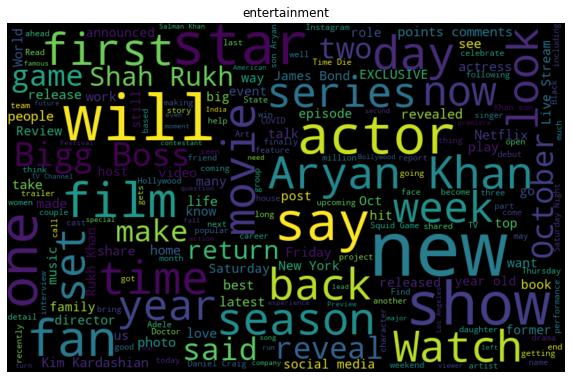

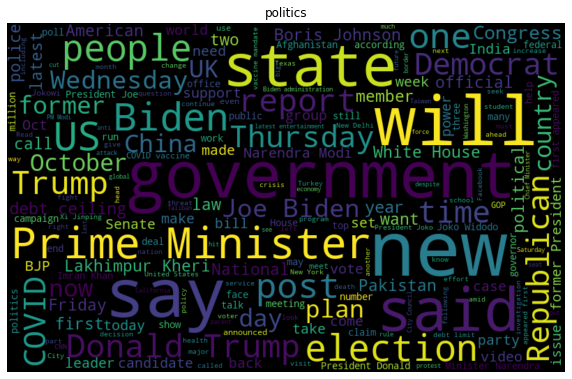

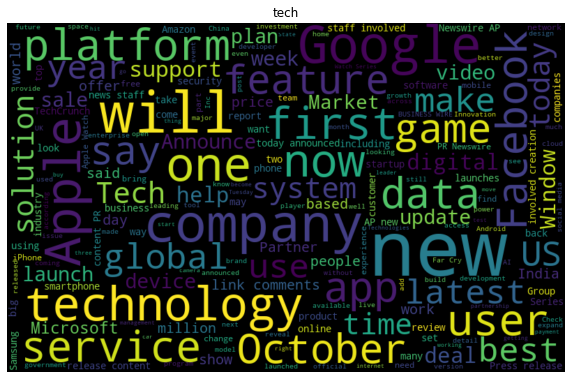

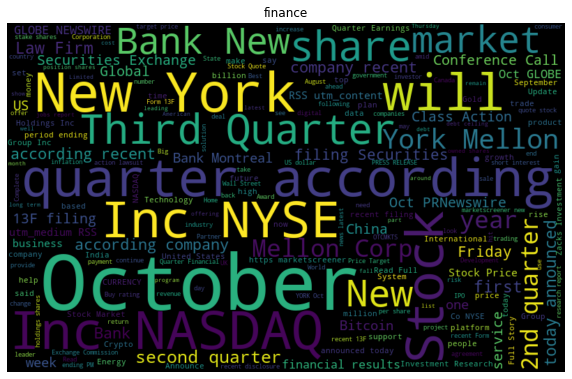

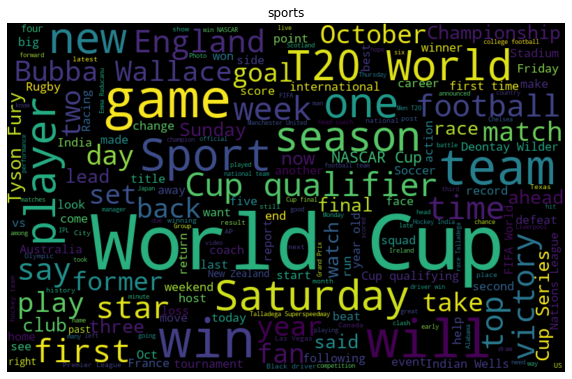

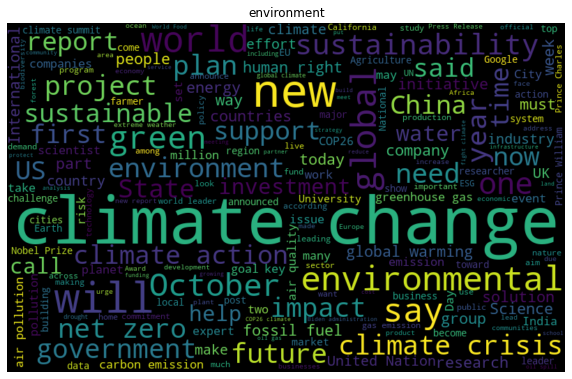

In [48]:
def create_wordcloud_visual(words,col,idx):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(col)
    plt.show()
    print('\n\n')

for idx,col in enumerate(list(X.label.unique())):
  subset=X[X.label==col]
  text=subset.title.values + ' ' + subset.excerpt.values
  words =" ".join(text)
  create_wordcloud_visual(words,col,idx)

### <u> Data Transformation </u>
1. Preparing the data for modelling.
2. Spliting data into training and testing inputs.
3. Converting data into numerical form.


In [49]:
ngram_range = (1,1)
max_features = 8000

In [14]:
X['final']  = X['stem'].apply(lambda arr: " ".join(arr))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X['final'], 
                                                    X['label'], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)


features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train

features_test = tfidf.transform(X_test).toarray()

labels_test = y_test

## Data Modelling.

### Using Ensemble models

#### Random Forest Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier
model_rand  = RandomForestClassifier(n_estimators=50,n_jobs=-1)
model_rand.fit(features_train, labels_train)
model_predictions = model_rand.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.7825345709414662
               precision    recall  f1-score   support

entertainment       0.73      0.76      0.74      1768
  environment       0.87      0.85      0.86      1551
      finance       0.76      0.76      0.76      1839
     politics       0.75      0.79      0.77      1777
       sports       0.85      0.86      0.86      1770
         tech       0.74      0.69      0.72      1853

     accuracy                           0.78     10558
    macro avg       0.79      0.78      0.78     10558
 weighted avg       0.78      0.78      0.78     10558



#### AdaBoost Classifier

In [36]:
from sklearn.ensemble import AdaBoostClassifier
adclf  = AdaBoostClassifier(n_estimators=200)
adclf.fit(features_train, labels_train)
model_predictions = adclf.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.6798636105322978
               precision    recall  f1-score   support

entertainment       0.48      0.76      0.58      1768
  environment       0.86      0.79      0.82      1551
      finance       0.71      0.66      0.68      1839
     politics       0.70      0.59      0.64      1777
       sports       0.83      0.77      0.80      1770
         tech       0.68      0.54      0.60      1853

     accuracy                           0.68     10558
    macro avg       0.71      0.68      0.69     10558
 weighted avg       0.70      0.68      0.68     10558



#### Extratrees Classifier

In [20]:
from sklearn.ensemble import ExtraTreesClassifier
exclf  = ExtraTreesClassifier(n_estimators=50)
exclf.fit(features_train, labels_train)
model_predictions = exclf.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.7952263686304224
               precision    recall  f1-score   support

entertainment       0.75      0.76      0.76      1768
  environment       0.86      0.88      0.87      1551
      finance       0.79      0.76      0.78      1839
     politics       0.75      0.80      0.78      1777
       sports       0.87      0.88      0.87      1770
         tech       0.76      0.71      0.73      1853

     accuracy                           0.80     10558
    macro avg       0.80      0.80      0.80     10558
 weighted avg       0.79      0.80      0.79     10558



### One vs Rest - Using SVM Model as Binary classifier

In [21]:
from sklearn.linear_model import SGDClassifier
sgd  = SGDClassifier()
sgd.fit(features_train, labels_train)
model_predictions = sgd.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.8131274862663384
               precision    recall  f1-score   support

entertainment       0.77      0.80      0.78      1768
  environment       0.86      0.90      0.88      1551
      finance       0.81      0.74      0.77      1839
     politics       0.78      0.81      0.80      1777
       sports       0.89      0.91      0.90      1770
         tech       0.77      0.72      0.75      1853

     accuracy                           0.81     10558
    macro avg       0.81      0.82      0.81     10558
 weighted avg       0.81      0.81      0.81     10558



### Naive_bayes - Multinomial Model

In [22]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(features_train, labels_train)
mnb_predictions = mnb.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, mnb_predictions))
print(classification_report(labels_test, mnb_predictions))

Accuracy:  0.7984466755067248
               precision    recall  f1-score   support

entertainment       0.80      0.77      0.79      1768
  environment       0.82      0.87      0.84      1551
      finance       0.78      0.73      0.76      1839
     politics       0.76      0.81      0.78      1777
       sports       0.90      0.91      0.91      1770
         tech       0.73      0.72      0.72      1853

     accuracy                           0.80     10558
    macro avg       0.80      0.80      0.80     10558
 weighted avg       0.80      0.80      0.80     10558



### Neural Network - ANN

In [23]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
labels_train = lb.fit_transform(labels_train)
labels_test =lb.transform(labels_test)


inputs = tf.keras.Input(shape=(features_train.shape[1],))
dense_1 = tf.keras.layers.Dense(128, activation='relu')(inputs)
dense_2 = tf.keras.layers.Dense(128, activation='relu')(dense_1)
outputs = tf.keras.layers.Dense(6, activation='softmax')(dense_2)


model = tf.keras.Model(inputs, outputs)

print(model.summary())
tf.keras.utils.plot_model(model)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    features_train,
    labels_train,
    validation_split=0.2,
    batch_size=32,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
        )
    ]
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000)]            0         
                                                                 
 dense (Dense)               (None, 128)               1024128   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 1,041,414
Trainable params: 1,041,414
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
1056/1056 [==============================] - 12s 11ms/step - loss: 0.7231 - accuracy: 0.7614 - val_loss: 0.5864 - val_accuracy: 0.8065
Epoch 2/20
1056/1056 [==========

In [24]:
ann_predictions = model.predict([features_test])
ann_predictions = np.argmax(ann_predictions,1)
ann_predictions = lb.inverse_transform(ann_predictions)
labels_test = lb.inverse_transform(labels_test)
labels_train = lb.inverse_transform(labels_train)
print('Accuracy: ', accuracy_score(labels_test, ann_predictions))
print(classification_report(labels_test, ann_predictions))

Accuracy:  0.7814927069520743
               precision    recall  f1-score   support

entertainment       0.76      0.72      0.74      1768
  environment       0.86      0.84      0.85      1551
      finance       0.76      0.74      0.75      1839
     politics       0.76      0.78      0.77      1777
       sports       0.90      0.86      0.88      1770
         tech       0.68      0.76      0.72      1853

     accuracy                           0.78     10558
    macro avg       0.79      0.78      0.78     10558
 weighted avg       0.78      0.78      0.78     10558



## Data Predictions.

### Creating a custom dataset for testing the Models

In [25]:
text_arr = [
    "LIVE BAN vs PAK 1st T20 2021 Live Cricket Score, T20 Live Match Latest Updates: Bangladesh Win Toss, Opt to Bat",
    "India vs New Zealand: Virat Kohli Sacrificed His Number 3 Position For Me, Says Suryakumar Yadav",
    "Certainly won't be playing international cricket after T20 World Cup 2022, says Matthew Wade",
    "John Abraham snatches fan’s phone for filming him. Watch what happens next",
    "Amyra Dastur’s Workout Routine Will Surely Be Your Motivation For The Day | Watch",
    "Salman Khan, Ranveer Singh, Shraddha Kapoor will be present at the opening ceremony of IFFI 2021",
    "Explained: All about the new annual information statement of the income tax department",
    "Personal Finance: Equity investing — It’s time to rebalance your investment portfolio",
    "Why traders can get by with AI-driven platforms, but long-term investors need real advisors",
    "Recent global warming ‘unprecedented' in 24,000 years, study finds",
    "COP26: India to co-lead Integrated Biorefineries Mission aimed at replacing fossil fuels",
    "51% cut in stubble burning this season against corresponding period last year: Air quality panel",
    "COVID: Germany shatters another record as Merkel, state leaders to meet",
    "Explained: What happened at Joe Biden-Xi Jinping summit, and why it matters to India",
    "PM Modi to host President Putin for one-to-one meeting on Dec 6",
    "Virtual reality has potential to change airway management training",
    "Scientists Build 256-Qubit Quantum Computer That's Unlike Anything Else",
    "Google Cloud teams up with NLP startup Cohere on multiyear partnership around TPUs"
]

In [27]:
text_df = pd.DataFrame(text_arr,columns=['news'])

### Functions to transform the news for model inputs 

In [28]:
import re
def convert(df,tfidf,model):
  df = df.copy()
  stop_words = set(stopwords.words('english'))
  df['news_token'] = df['news'].apply(lambda x: word_tokenize(x))
  f = lambda x: [item.lower() for item in x if item.lower() not in stop_words]
  df['news_token'] = df['news_token'].apply(f)
  
  def check_punc(word):
    if re.match(r'([A-Za-z]+)',word):
      return True
    else:
      return False

  df['news_token'] = df['news_token'].apply(lambda x:list(filter(check_punc,x)))
  # df['comb_token'] = df['title'].apply(lambda x: blankline_tokenize(x))
  ps = PorterStemmer()
  f = lambda arr: [ps.stem(word) for word in arr]
  df['news_token'] = df['news_token'].apply(f)

  df['news_token'] = df['news_token'].apply(lambda arr: " ".join(arr))
  df['tfidf'] = df['news_token'].apply(lambda x: tfidf.transform(pd.Series(x)).toarray())
  df['type'] = df['tfidf'].apply(lambda x: model.predict(x))
  df =df.drop(['news_token','tfidf'],axis =1)
  return df



### Predicting the news.

In [29]:
ans = convert(text_df,tfidf,model_rand)
ans

,news,type
0,LIVE BAN vs PAK 1st T20 2021 Live Cricket Scor...,[sports]
1,India vs New Zealand: Virat Kohli Sacrificed H...,[sports]
2,Certainly won't be playing international crick...,[sports]
3,John Abraham snatches fan’s phone for filming ...,[entertainment]
4,Amyra Dastur’s Workout Routine Will Surely Be ...,[entertainment]
5,"Salman Khan, Ranveer Singh, Shraddha Kapoor wi...",[entertainment]
6,Explained: All about the new annual informatio...,[politics]
7,Personal Finance: Equity investing — It’s time...,[finance]
8,Why traders can get by with AI-driven platform...,[finance]
9,"Recent global warming ‘unprecedented' in 24,00...",[environment]


In [30]:
ans = convert(text_df,tfidf,mnb)
ans

,news,type
0,LIVE BAN vs PAK 1st T20 2021 Live Cricket Scor...,[sports]
1,India vs New Zealand: Virat Kohli Sacrificed H...,[sports]
2,Certainly won't be playing international crick...,[sports]
3,John Abraham snatches fan’s phone for filming ...,[entertainment]
4,Amyra Dastur’s Workout Routine Will Surely Be ...,[entertainment]
5,"Salman Khan, Ranveer Singh, Shraddha Kapoor wi...",[entertainment]
6,Explained: All about the new annual informatio...,[finance]
7,Personal Finance: Equity investing — It’s time...,[finance]
8,Why traders can get by with AI-driven platform...,[finance]
9,"Recent global warming ‘unprecedented' in 24,00...",[environment]


In [31]:
ans = convert(text_df,tfidf,model)
ans['type'] = ans['type'].apply(lambda arr: lb.inverse_transform(np.argmax(arr,1)))
ans

,news,type
0,LIVE BAN vs PAK 1st T20 2021 Live Cricket Scor...,[sports]
1,India vs New Zealand: Virat Kohli Sacrificed H...,[politics]
2,Certainly won't be playing international crick...,[sports]
3,John Abraham snatches fan’s phone for filming ...,[entertainment]
4,Amyra Dastur’s Workout Routine Will Surely Be ...,[entertainment]
5,"Salman Khan, Ranveer Singh, Shraddha Kapoor wi...",[entertainment]
6,Explained: All about the new annual informatio...,[politics]
7,Personal Finance: Equity investing — It’s time...,[finance]
8,Why traders can get by with AI-driven platform...,[tech]
9,"Recent global warming ‘unprecedented' in 24,00...",[environment]


In [37]:
ans = convert(text_df,tfidf,adclf)
ans

,news,type
0,LIVE BAN vs PAK 1st T20 2021 Live Cricket Scor...,[sports]
1,India vs New Zealand: Virat Kohli Sacrificed H...,[sports]
2,Certainly won't be playing international crick...,[sports]
3,John Abraham snatches fan’s phone for filming ...,[entertainment]
4,Amyra Dastur’s Workout Routine Will Surely Be ...,[entertainment]
5,"Salman Khan, Ranveer Singh, Shraddha Kapoor wi...",[entertainment]
6,Explained: All about the new annual informatio...,[entertainment]
7,Personal Finance: Equity investing — It’s time...,[finance]
8,Why traders can get by with AI-driven platform...,[finance]
9,"Recent global warming ‘unprecedented' in 24,00...",[environment]


In [34]:
ans = convert(text_df,tfidf,exclf)
ans

,news,type
0,LIVE BAN vs PAK 1st T20 2021 Live Cricket Scor...,[sports]
1,India vs New Zealand: Virat Kohli Sacrificed H...,[sports]
2,Certainly won't be playing international crick...,[sports]
3,John Abraham snatches fan’s phone for filming ...,[entertainment]
4,Amyra Dastur’s Workout Routine Will Surely Be ...,[tech]
5,"Salman Khan, Ranveer Singh, Shraddha Kapoor wi...",[entertainment]
6,Explained: All about the new annual informatio...,[finance]
7,Personal Finance: Equity investing — It’s time...,[finance]
8,Why traders can get by with AI-driven platform...,[finance]
9,"Recent global warming ‘unprecedented' in 24,00...",[environment]


In [35]:
ans = convert(text_df,tfidf,sgd)
ans

,news,type
0,LIVE BAN vs PAK 1st T20 2021 Live Cricket Scor...,[sports]
1,India vs New Zealand: Virat Kohli Sacrificed H...,[sports]
2,Certainly won't be playing international crick...,[sports]
3,John Abraham snatches fan’s phone for filming ...,[entertainment]
4,Amyra Dastur’s Workout Routine Will Surely Be ...,[entertainment]
5,"Salman Khan, Ranveer Singh, Shraddha Kapoor wi...",[entertainment]
6,Explained: All about the new annual informatio...,[finance]
7,Personal Finance: Equity investing — It’s time...,[finance]
8,Why traders can get by with AI-driven platform...,[finance]
9,"Recent global warming ‘unprecedented' in 24,00...",[environment]
